### MSc Computer Science, Data Science @UniPD
### Optimization Methods for Data Science
---

# Packages

In [2]:
from os.path import isdir
from os import mkdir

env = 'colab'  # 'pc', 'colab'
git_download_path = 'https://raw.githubusercontent.com/PashaIanko/Semi-Supervised-Labelling/accuracy_track/'
experiment = 'ExpGD10000/'

save_dir = ''
if env == 'pc':
    save_dir = f'C:/Users/79137/Pasha/2. UNIPD/Semester 2/Optimization for Data Science/Homeworks/HW 1/Semi-Supervised-Labelling/'
elif env == 'colab':
    save_dir = f'/content/drive/MyDrive/UNIPD/ODS/HW1/'

In [3]:
%%capture

def download_files(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}

if env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    files = [
           'BCGDSolver.py',
           'DataProperties.py',
           'GradientDescentSolver.py',
           'GradientSolver.py',
           'Utils.py'  
    ]

    url_dict = {file: git_download_path + file for file in files}
    download_files(url_dict)

# Saving directory

In [4]:
full_dir = f'{save_dir}{experiment}'
assert(isdir(save_dir))

if not isdir(full_dir):
    mkdir(full_dir)

assert(isdir(full_dir))

In [5]:
from sklearn.datasets import make_blobs
import numpy as np

from sklearn import datasets
from sklearn.metrics import accuracy_score
import pandas as pd
import timeit

# Plotting
import matplotlib.pyplot as plt

In [6]:
import Utils
import GradientSolver
import GradientDescentSolver
import DataProperties
import BCGDSolver
import importlib

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        Utils,
        GradientSolver,
        GradientDescentSolver,
        DataProperties,
        BCGDSolver
    ]
)

from Utils import *
from GradientSolver import GradientSolver
from GradientDescentSolver import GradientDescentSolver
from DataProperties import DataProperties
from BCGDSolver import BCGDSolver

# Data preparation

In [7]:
# Fix states
sklearn_random_state = 42
numpy_seed = 42

np.random.seed(numpy_seed)

In [14]:
# %%timeit
X, Y = make_blobs(
    n_samples = DataProperties.n_samples,
    centers = DataProperties.n_clusters,
    n_features = DataProperties.n_dims,
    random_state = sklearn_random_state,
    cluster_std = 1.5
)


def euclidian_similarity(Xi, Xj):
    return 1 / (norm(Xi - Xj) + 0.001)

In [15]:
# %%timeit

# Old inefficient weights calculation
# weights = calc_weight_matrix(X, weight_func = None)

from sklearn.metrics import pairwise_distances

weights = pairwise_distances(X, metric = 'euclidean')
weights = 1 / (weights + 0.001)
assert(weights.shape == (DataProperties.n_samples, DataProperties.n_samples))

Data shape: X: (10000, 2), Y: (10000,)


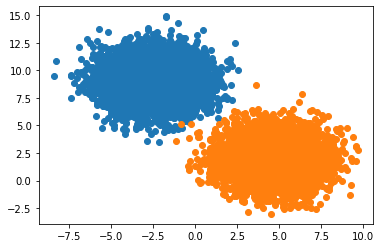

In [16]:
Y = Y.astype('float64')
clusters = np.unique(Y)

print(f'Data shape: X: {X.shape}, Y: {Y.shape}')
plot_clusters(X, Y)

## Unlabel subset and visualize

Found 5000 instances of object 0.0
We have to delabel 4750 instances
Found 5000 instances of object 1.0
We have to delabel 4750 instances

    We have 9500 unlabeled data
    Out of 10000
    


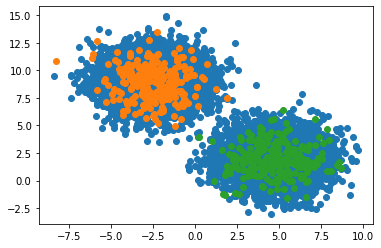

In [17]:
Y_delabeled = delabel_data(
    Y,
    labeled_percent = DataProperties.labeled_percentage,
    delabel_value = DataProperties.unlabeled
)

print(
    f'''
    We have {len(Y_delabeled[Y_delabeled == DataProperties.unlabeled])} unlabeled data
    Out of {len(Y_delabeled)}
    '''
)

plot_clusters(X, Y_delabeled)

- Up to now, we have the clustered data, saved correct labelling (Y) and delabelled data (Y_delabelled)
- For the unlabelled y variables, the loss function depends on the (y_1, ..., y_U) unlabeled parameters. Each of the
parameters is independent on others, and can be 0 or 1 (for **binary clustering problem**). This is why we will be searching
for **optimal solution in the R^(U)** space, which yields minimum to the **loss function**

In [18]:
import collections
class_stats = collections.Counter(Y_delabeled)
assert(len(class_stats.keys()) == 3)  # 2 labeled classes and 1 unlabeled
print(class_stats)

Counter({-1000000.0: 9500, 0.0: 250, 1.0: 250})


# Gradient descent

In [19]:
solver = GradientDescentSolver(
    similarity_func = None, # euclidian_similarity,
    lr_strategy = 'lr_constant',  # search for alpha_k
    learning_rate = 0.00001
)

In [20]:
Y_preds_GD = solver.solve(
    X, 
    Y_delabeled,
    Y_true = Y,
    iter_limit = 3,
    delta_loss_limit = 0.008, 
    stop_loss = 150,
    weight_matrix = weights
)

Iteration: 0, Loss: 411902.74232982687, delta loss: 411902.74232982687
Iteration: 1, Loss: 410322.9231387205, delta loss: 1579.8191911063623
Iteration: 2, Loss: 408824.23716645007, delta loss: 1498.6859722704394




Accuracy: 0.9995


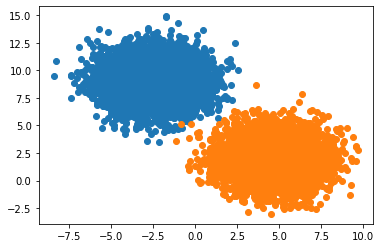

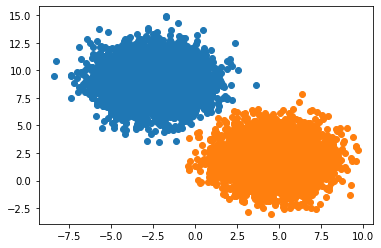

In [21]:
plot_clusters(X, Y)
plot_clusters(X, Y_preds_GD)
print(f'Accuracy: {accuracy_score(Y, Y_preds_GD)}')

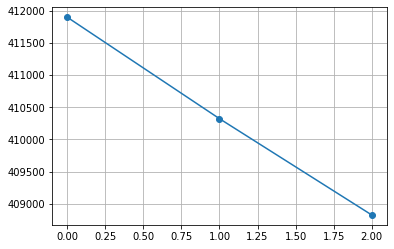

In [22]:
plt.plot(solver.losses, marker = 'o')
plt.grid()

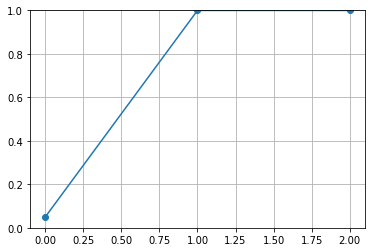

In [23]:
plt.plot(solver.accuracies, marker = 'o')
plt.ylim([0, 1])
plt.grid()

# Block coordinates gradient descent (randomized)

## BCGD random permutations

In [ ]:
random_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = None,

    bcgd_strategy = 'random permutation',
)

In [ ]:
Y_preds_BCGD_permutation = random_solver.solve(
    X, 
    Y_delabeled, 
    Y_true = Y,
    iter_limit = 6,
    delta_loss_limit = 0.008,
    stop_loss= 0,
    weight_matrix = weights
)

Iteration: 0, Loss: 1965.1493896569013, Delta: 1965.1493896569013
Iteration: 1, Loss: 1955.3618918675493, Delta: 9.787497789352074
Iteration: 2, Loss: 1949.7535311330728, Delta: 5.608360734476491
Iteration: 3, Loss: 1946.4246366213988, Delta: 3.3288945116739797
Iteration: 4, Loss: 1944.391947346278, Delta: 2.0326892751209016
Iteration: 5, Loss: 1943.1224198460893, Delta: 1.2695275001885875


Accuracy: 0.891


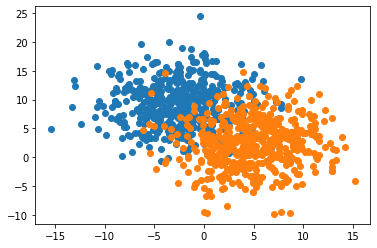

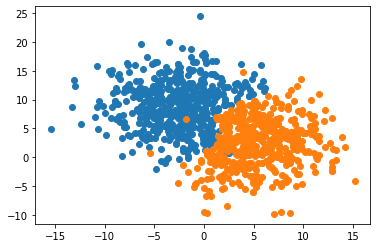

In [ ]:
plot_clusters(X, Y)
plot_clusters(X, Y_preds_BCGD_permutation)
print(f'Accuracy: {accuracy_score(Y, Y_preds_BCGD_permutation)}')

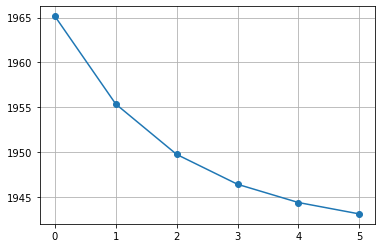

In [ ]:
plt.plot(random_solver.losses, marker = 'o')
plt.grid()

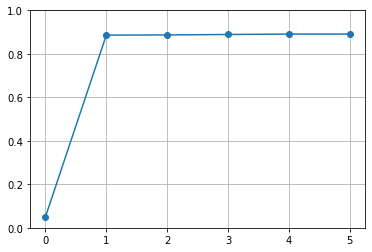

In [ ]:
plt.plot(random_solver.accuracies, marker = 'o')
plt.ylim([0, 1])
plt.grid()

## BCGD random sampling

In [ ]:
BCGD_RS_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = None,
    bcgd_strategy = 'random sampling'
)

In [ ]:
Y_preds_BCGD_sampling = BCGD_RS_solver.solve(
    X = X, 
    Y = Y_delabeled,
    Y_true = Y,
    iter_limit = 10, #  * len(Y_delabeled[Y_delabeled == DataProperties.unlabeled]),
    delta_loss_limit = 0.0,
    stop_loss= 0,
    weight_matrix = weights
)

Iteration: 0, Loss: 1965.1493896569013, Delta: 1965.1493896569013
Iteration: 1, Loss: 1965.1434853608641, Delta: 0.0059042960372153175
Iteration: 2, Loss: 1965.1429973936165, Delta: 0.0004879672476363339
Iteration: 3, Loss: 1965.1316517839382, Delta: 0.011345609678301116
Iteration: 4, Loss: 1965.1298608433128, Delta: 0.0017909406253693305
Iteration: 5, Loss: 1965.1240447744956, Delta: 0.005816068817239284
Iteration: 6, Loss: 1965.1222759634325, Delta: 0.0017688110631297604
Iteration: 7, Loss: 1965.1150468593964, Delta: 0.007229104036014178
Iteration: 8, Loss: 1965.1093773596779, Delta: 0.005669499718578663
Iteration: 9, Loss: 1965.1004491972935, Delta: 0.008928162384336247


Accuracy: 0.529


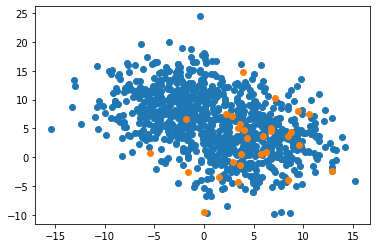

In [ ]:
plot_clusters(
    X, Y_preds_BCGD_sampling
)
print(f'Accuracy: {accuracy_score(Y, Y_preds_BCGD_sampling)}')

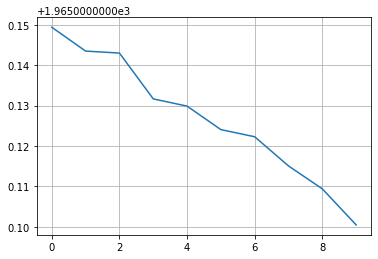

In [ ]:
plt.plot(BCGD_RS_solver.losses)
plt.grid()

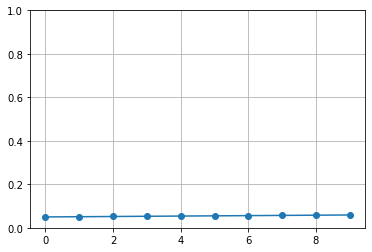

In [ ]:
plt.plot(BCGD_RS_solver.accuracies, marker = 'o')
plt.ylim([0, 1])
plt.grid()

## BCGD cyclic

In [ ]:
BCGD_cyclic_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = None,
    bcgd_strategy = 'cyclic'
)

In [ ]:
Y_preds_BCGD_cyclic = BCGD_cyclic_solver.solve(
    X,
    Y_delabeled, 
    Y_true = Y,
    iter_limit = 6, 
    delta_loss_limit = 0.0001,
    stop_loss = 0,
    weight_matrix = weights
)

Iteration: 0, Loss: 1965.1493896569013, Delta: 1965.1493896569013
Iteration: 1, Loss: 1955.360387447002, Delta: 9.789002209899309
Iteration: 2, Loss: 1949.7498537516992, Delta: 5.61053369530282
Iteration: 3, Loss: 1946.4189762234603, Delta: 3.3308775282389433
Iteration: 4, Loss: 1944.3854067336222, Delta: 2.0335694898381007
Iteration: 5, Loss: 1943.115895411761, Delta: 1.2695113218612732


Accuracy: 0.891


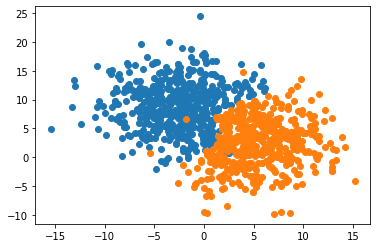

In [ ]:
print(f'Accuracy: {accuracy_score(Y_preds_BCGD_cyclic, Y)}')
plot_clusters(
    X, Y_preds_BCGD_cyclic
)

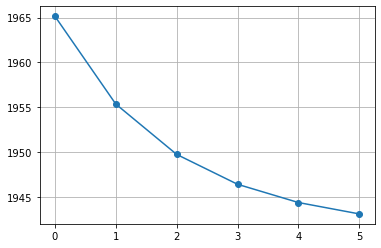

In [ ]:
plt.plot(BCGD_cyclic_solver.losses, marker = 'o')
plt.grid()

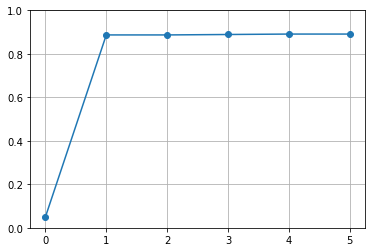

In [ ]:
plt.plot(BCGD_cyclic_solver.accuracies, marker = 'o')
plt.ylim([0, 1])
plt.grid()

# Model comparison

We will compare models based on:
- Clustering metrics
- CPU time
- Number of iterations
- Loss curves
- Distance metrics

In [24]:
learning_rate_strategy = 'lr_constant'
simil_func = None  # No feature yet
lr = 0.00001

gd_solver = GradientDescentSolver(
    similarity_func = simil_func,
    lr_strategy = learning_rate_strategy,
    learning_rate = lr
)

bcgd_permut_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random permutation',
)

bcgd_sampling_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random sampling',
)

bcgd_cyclic_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'cyclic',
)

solvers = {
    'GD': gd_solver,
    # 'BCGD permutation': bcgd_permut_solver,
    # 'BCGD cyclic': bcgd_cyclic_solver,
    # 'BCGD sampling': bcgd_sampling_solver,
}

In [35]:
def compare_models(solvers_dict, X, Y_true, Y_delabeled, iters_limit, delta_loss_limit, stop_loss, weights_matrix):
    predictions = {k:None for k in solvers_dict.keys()}
    losses = {k:None for k in solvers_dict.keys()}
    n_iterations = {k:None for k in solvers_dict.keys()}
    cpu_times_total = {k:None for k in solvers_dict.keys()}

    for model_name, model in solvers_dict.items():
        print(f'Fitting {model_name}')
        start = timeit.default_timer()
        Y_preds = model.solve(
            X,
            Y_delabeled,
            Y_true = Y_true,
            iter_limit = iters_limit,
            delta_loss_limit = delta_loss_limit,
            stop_loss= stop_loss,
            weight_matrix = weights_matrix
        )
        end = timeit.default_timer()
        predictions[model_name] = Y_preds
        losses[model_name] = model.losses
        n_iterations[model_name] = model.n_iterations
        cpu_times_total[model_name] = end - start
    

    return predictions, losses, n_iterations, cpu_times_total

In [36]:
iters_limit = 10
delta_loss_limit = 0.0001
stop_loss= 200  # 4000


preds, losses, n_iters, cpu_times_total = compare_models(
        solvers,
        X,
        Y_delabeled = Y_delabeled,
        Y_true = Y,
        iters_limit = iters_limit,
        delta_loss_limit = delta_loss_limit,
        stop_loss = stop_loss,
        weights_matrix =  weights
    )

Fitting GD
Iteration: 0, Loss: 411902.74232982687, delta loss: 411902.74232982687
Iteration: 1, Loss: 410322.9231387205, delta loss: 1579.8191911063623
Iteration: 2, Loss: 408824.23716645007, delta loss: 1498.6859722704394
Iteration: 3, Loss: 407401.91535688314, delta loss: 1422.321809566929


KeyboardInterrupt: ignored

In [28]:
accuracies = {name: solver.accuracies for name, solver in solvers.items()}
cpu_times = {name: solver.cpu_times for name, solver in solvers.items()}

## Saving data

In [29]:
# iters_limit = 17
# delta_loss_limit = 0.0001
# stop_loss= 21000  # 4000

experiment_params = pd.DataFrame(
    {
        'iters_limit': [iters_limit],
        'd_loss_limit': [delta_loss_limit],
        'stop_loss': [stop_loss],
        'learning_rate': [lr],
        'n points': [DataProperties.n_samples]
    },
    # index = False
)

experiment_params.to_csv(full_dir + 'experiment_params.csv')
experiment_params.head()

,iters_limit,d_loss_limit,stop_loss,learning_rate,n points
0,5,0.0001,200,0.00001,10000


In [30]:
accuracies

{'GD': [0.05, 0.9996, 0.9996, 0.9995, 0.9995]}

In [31]:
results = pd.DataFrame()

# fill losses
for model_name, loss in losses.items():
    new = pd.DataFrame({f'{model_name} loss': loss})
    results = pd.concat([results, new], axis = 1)
    # results[f'{model_name} loss'] = loss

for model_name, cpu_time in cpu_times.items():
    new = pd.DataFrame({f'{model_name} cpu': cpu_time})
    results = pd.concat([results, new], axis = 1)
    # results[f'{model_name} cpu'] = cpu_time

for model_name, acc in accuracies.items():
    new = pd.DataFrame({f'{model_name} acc': acc})
    results = pd.concat([results, new], axis = 1)


results.to_csv(full_dir + 'res.csv')
results.head()

,GD loss,GD cpu,GD acc
0,411902.742330,129.722159,0.0500
1,410322.923139,379.174083,0.9996
2,408824.237166,621.618385,0.9996
3,407401.915357,871.115131,0.9995
4,406051.531514,1114.261903,0.9995


,CPU total time,N iterations,Final accuracy,CPU total time_norm,N iterations_norm,Final accuracy_norm
GD,1230.347575,5,0.9995,1.0,1.0,1.0


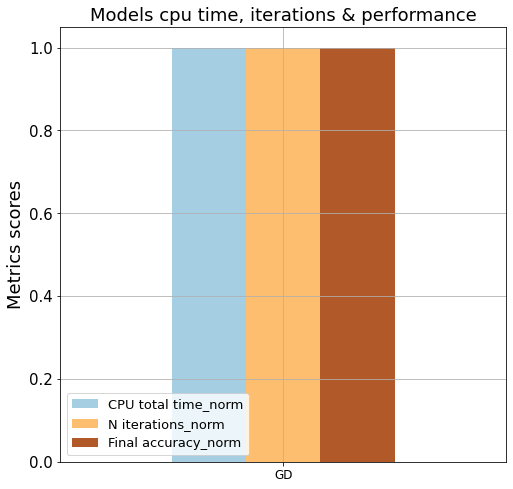

In [32]:
bar_metrics = pd.DataFrame.from_dict(cpu_times_total, orient='index', columns = ['CPU total time'])
bar_metrics['N iterations'] = n_iters.values()

final_accuracies = {name: acc[-1] for name, acc in accuracies.items()}
bar_metrics['Final accuracy'] = final_accuracies.values()



normalize_cols(bar_metrics)
cols_to_plot = [c for c in bar_metrics.columns if 'norm' in c]

plot_bar_metrics(bar_metrics.loc[:, cols_to_plot])
bar_metrics.to_csv(full_dir + 'metrics res.csv')

bar_metrics.head()

## Graphics

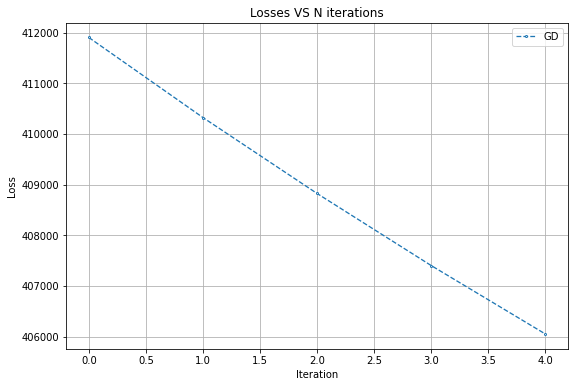

In [33]:
def plot_curves(curves_dict, title, y_label, figsize):
    _, ax = plt.subplots(figsize = figsize)

    for _, curve_res in curves_dict.items():
        ax.plot(
            curve_res,
            marker = 'o',
            linestyle = '--',
            linewidth = 1.3,
            markerfacecolor = 'white',
            markersize = 2
        )
    plt.legend(list(curves_dict.keys()))
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel(y_label)
    plt.grid()


# plot_curves({'Cyclic':losses['BCGD cyclic']}, 'Losses cyclic', y_label = 'Loss')
# plot_curves({'GD':losses['GD']}, 'Losses GD', y_label = 'Loss')
plot_curves(
    losses,
    'Losses VS N iterations', 
    y_label = 'Loss',
    figsize = (9, 6)
)

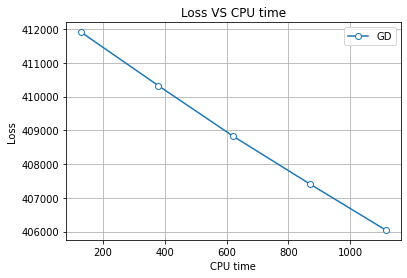

In [34]:
def plot_losses_vs_cpu(losses_, cpu_times_):
    assert(list(losses_.keys()) == list(cpu_times_.keys()))

    _, ax = plt.subplots()

    for model_name, loss in losses_.items():
        cpu_time = cpu_times_[model_name]

        ax.plot(
            cpu_time,
            loss,
            marker = 'o',
            markerfacecolor = 'white'
        )
    plt.xlabel('CPU time')
    plt.ylabel('Loss')
    plt.title('Loss VS CPU time')
    plt.legend(list(losses_.keys()))
    plt.grid()


plot_losses_vs_cpu(losses, cpu_times)

# Real dataset

In [ ]:
# df = pd.read_csv('Pokemon.csv')

In [ ]:
# df.head()

,number,name,type1,type2,total,hp,attack,defense,sp_attack,sp_defense,speed,generation,legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,3,Gigantamax Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False


In [ ]:
# df.head()
# X_real = df.loc[:, ['total', 'sp_attack']].values
# Y_real = df['legendary'].astype('int').values


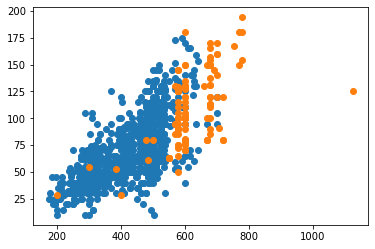

In [ ]:
# plot_clusters(
#     X_real,
#     Y_real
# )

In [ ]:
# Y_real_delabeled = delabel_data(
#     Y_real,
#     labeled_percent = 0.16, # DataProperties.labeled_percentage,
#     delabel_value = DataProperties.unlabeled
# )

Found 954 instances of object 0
We have to delabel 801 instances
Found 118 instances of object 1
We have to delabel 99 instances


In [ ]:
# wine=datasets.load_wine()

# #Conver to pandas dataframe
# data=pd.DataFrame(data=np.c_[wine['data'],wine['target']],columns=wine['feature_names']+['target'])

# data = data.loc[
#     (data['target'] == 1) | (data['target'] == 0),
#     ['od280/od315_of_diluted_wines', 'alcohol', 'target']
# ]

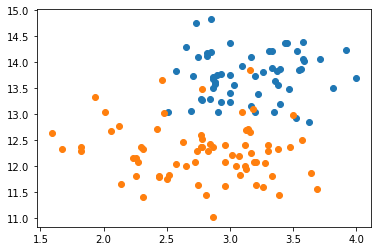

In [ ]:
# X_real = data.loc[
#     :,
#     ['od280/od315_of_diluted_wines', 'alcohol']
# ].values
# Y_real = data['target'].values

# plot_clusters(
#     X_real,
#     Y_real
# )

In [ ]:
# solver = GradientDescentSolver(
#     lr_strategy = 'lr_constant',
#     learning_rate = 0.0001,
#     similarity_func = None
# )

# Y_real_preds = solver.solve(
#     X_real,
#     Y_real_delabeled,
#     iter_limit=5,
#     delta_loss_limit = 0.003,
#     stop_loss = 20
# )

Iteration: 0, Loss: 24173.807351957803, delta loss: 24173.807351957803
Iteration: 1, Loss: 24173.807351957803, delta loss: 0.0
Iteration: 2, Loss: 24173.807351957803, delta loss: 0.0
Iteration: 3, Loss: 24173.807351957803, delta loss: 0.0
Iteration: 4, Loss: 24173.807351957803, delta loss: 0.0


